In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

# application_train

In [2]:
def application_data():

    df = pd.read_csv('C:/Users/Amgad/Downloads/voda/data/application_train.csv')
    test_df = pd.read_csv('C:/Users/Amgad/Downloads/voda/data/application_test.csv')

    df = df.append(test_df).reset_index()
    df = df[df['CODE_GENDER'] != 'XNA']

    lbe = LabelEncoder()

    for col in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
            df[col] = lbe.fit_transform(df[col])

    df = pd.get_dummies(df, dummy_na = True)

    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)
    df['NEW_DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['NEW_INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['NEW_INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['NEW_ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['NEW_PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    df.drop("index", axis = 1, inplace =  True)

    df.columns = pd.Index(["APP_" + col for col in df.columns.tolist()])

    df.rename(columns={"APP_SK_ID_CURR":"SK_ID_CURR"}, inplace = True)

    df.rename(columns={"APP_TARGET":"TARGET"}, inplace = True)
    
    return df

# bureau & bureau_balance

In [3]:
def bureau_bb():


    bb = pd.read_csv('C:/Users/Amgad/Downloads/voda/data/bureau_balance.csv')
    bb = pd.get_dummies(bb, dummy_na = True)

    agg_list = {"MONTHS_BALANCE":"count",
                "STATUS_0":["sum","mean"],
                "STATUS_1":["sum"],
                "STATUS_2":["sum"],
                "STATUS_3":["sum"],
                "STATUS_4":["sum"],
                "STATUS_5":["sum"],
                "STATUS_C":["sum","mean"],
                "STATUS_X":["sum","mean"] }

    bb_agg = bb.groupby("SK_ID_BUREAU").agg(agg_list)

    bb_agg.columns = pd.Index([col[0] + "_" + col[1].upper() for col in bb_agg.columns.tolist()])

    bb_agg['NEW_STATUS_SCORE'] = bb_agg['STATUS_1_SUM'] + bb_agg['STATUS_2_SUM']^2 + bb_agg['STATUS_3_SUM']^3 + bb_agg['STATUS_4_SUM']^4 + bb_agg['STATUS_5_SUM']^5

    bb_agg.drop(['STATUS_1_SUM','STATUS_2_SUM','STATUS_3_SUM','STATUS_4_SUM','STATUS_5_SUM'], axis=1,inplace=True)

    bureau = pd.read_csv('C:/Users/Amgad/Downloads/voda/data/bureau.csv')
    bureau_and_bb = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')

    bureau_and_bb['CREDIT_TYPE'] = bureau_and_bb['CREDIT_TYPE'].replace(['Car loan',
              'Mortgage',
              'Microloan',
              'Loan for business development', 
              'Another type of loan',
              'Unknown type of loan', 
              'Loan for working capital replenishment',
              "Loan for purchase of shares (margin lending)",                                                
              'Cash loan (non-earmarked)', 
              'Real estate loan',
              "Loan for the purchase of equipment", 
              "Interbank credit", 
              "Mobile operator loan"], 'Rare')


    bureau_and_bb['CREDIT_ACTIVE'] = bureau_and_bb['CREDIT_ACTIVE'].replace(['Bad debt','Sold'], 'Active')

    bureau_and_bb = pd.get_dummies(bureau_and_bb, columns = ["CREDIT_TYPE","CREDIT_ACTIVE"])

    bureau_and_bb.drop(["SK_ID_BUREAU","CREDIT_CURRENCY"], inplace = True, axis = 1)

    bureau_and_bb["NEW_MONTHS_CREDIT"]= round((bureau_and_bb.DAYS_CREDIT_ENDDATE - bureau_and_bb.DAYS_CREDIT)/30)
    agg_list = {
          "SK_ID_CURR":["count"],
          "DAYS_CREDIT":["min","max"],
          "CREDIT_DAY_OVERDUE":["sum","mean","max"],     
          "DAYS_CREDIT_ENDDATE":["max","min"],
          "DAYS_ENDDATE_FACT":["max","min"],
          "AMT_CREDIT_MAX_OVERDUE":["mean","max","min"],
          "CNT_CREDIT_PROLONG":["sum","mean","max","min"],
          "AMT_CREDIT_SUM":["mean","max","min"],            
          "AMT_CREDIT_SUM_DEBT":["sum","mean","max"],
          "AMT_CREDIT_SUM_LIMIT":["sum","mean","max"],
          'AMT_CREDIT_SUM_OVERDUE':["sum","mean","max"], 
          'DAYS_CREDIT_UPDATE':["max","min"],
          'AMT_ANNUITY':["sum","mean"],
          'MONTHS_BALANCE_COUNT':["sum"], 
          'STATUS_0_SUM':["sum"],         
          'STATUS_0_MEAN':["mean"], 
          'STATUS_C_SUM':["sum"], 
          'STATUS_C_MEAN':["mean"],
          'CREDIT_ACTIVE_Active':["sum","mean"], 
          'CREDIT_ACTIVE_Closed':["sum","mean"], 
          'CREDIT_TYPE_Rare':["sum","mean"],      
          'CREDIT_TYPE_Consumer credit':["sum","mean"], 
          'CREDIT_TYPE_Credit card':["sum","mean"],
          "NEW_MONTHS_CREDIT":["count","sum","mean","max","min"]}

    bureau_and_bb_agg = bureau_and_bb.groupby("SK_ID_CURR").agg(agg_list).reset_index()
    bureau_and_bb_agg.columns = pd.Index(["BB_" + col[0] + "_" + col[1].upper() for col in bureau_and_bb_agg.columns.tolist()])

    bureau_and_bb_agg["BB_NEW_AMT_CREDIT_SUM_RANGE"] = bureau_and_bb_agg["BB_AMT_CREDIT_SUM_MAX"] - bureau_and_bb_agg["BB_AMT_CREDIT_SUM_MIN"]

    bureau_and_bb_agg["BB_NEW_DAYS_CREDIT_RANGE"]= round((bureau_and_bb_agg["BB_DAYS_CREDIT_MAX"] - bureau_and_bb_agg["BB_DAYS_CREDIT_MIN"])/(30 * bureau_and_bb_agg["BB_SK_ID_CURR_COUNT"]))
    agg_list = {
            'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
            'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
            'DAYS_CREDIT_UPDATE': ['mean'],
            'CREDIT_DAY_OVERDUE': ['max', 'mean'],
            'AMT_CREDIT_MAX_OVERDUE': ['mean'],
            'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
            'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
            'AMT_CREDIT_SUM_OVERDUE': ['mean'],
            'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
            'AMT_ANNUITY': ['max', 'mean'],
            'CNT_CREDIT_PROLONG': ['sum']
        }

    active = bureau_and_bb[bureau_and_bb['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(agg_list)
    active_agg.columns = pd.Index(['BB_NEW_ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_and_bb_agg.rename(columns = {'BB_SK_ID_CURR_': 'SK_ID_CURR'}, inplace = True)
    bureau_and_bb_agg = bureau_and_bb_agg.join(active_agg, how='left', on='SK_ID_CURR')

    closed = bureau_and_bb[bureau_and_bb['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(agg_list)
    closed_agg.columns = pd.Index(['BB_NEW_CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_and_bb_agg = bureau_and_bb_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    
    return bureau_and_bb_agg

# installments_payments

In [4]:
def installments_payments():
    ins = pd.read_csv('C:/Users/Amgad/Downloads/voda/data/installments_payments.csv')
    ins['NEW_DAYS_PAID_EARLIER'] = ins['DAYS_INSTALMENT']-ins['DAYS_ENTRY_PAYMENT']

    ins['NEW_NUM_PAID_LATER'] = ins['NEW_DAYS_PAID_EARLIER'].map(lambda x: 1 if x<0 else 0)
    agg_list = {'NUM_INSTALMENT_VERSION':['nunique'],
               'NUM_INSTALMENT_NUMBER':'max',
               'DAYS_INSTALMENT':['min','max'],
               'DAYS_ENTRY_PAYMENT':['min','max'],
               'AMT_INSTALMENT':['min','max','sum','mean'],
               'AMT_PAYMENT':['min','max','sum','mean'],
               'NEW_DAYS_PAID_EARLIER':'mean',
               'NEW_NUM_PAID_LATER':'sum'}

    ins_agg = ins.groupby('SK_ID_PREV').agg(agg_list)

    ins_agg.columns = pd.Index(["INS_" + e[0] + '_' + e[1].upper() for e in ins_agg.columns.tolist()])

    ins_agg.drop(['INS_DAYS_INSTALMENT_MIN',
                   'INS_DAYS_INSTALMENT_MAX',
                   'INS_DAYS_ENTRY_PAYMENT_MIN',
                   'INS_DAYS_ENTRY_PAYMENT_MAX'],axis=1,inplace=True)

    ins_agg['INS_NEW_PAYMENT_PERC'] = ins_agg['INS_AMT_PAYMENT_SUM'] / ins_agg['INS_AMT_INSTALMENT_SUM']
    ins_agg['INS_NEW_PAYMENT_DIFF'] = ins_agg['INS_AMT_INSTALMENT_SUM'] - ins_agg['INS_AMT_PAYMENT_SUM']
    
    agg_list_previous_application = {}
    for col in ins_agg.columns:
        agg_list_previous_application[col] = ['mean',"min","max","sum"]
    
    ins_agg.reset_index(inplace = True) 
    
    return agg_list_previous_application, ins_agg

# pos_cash_balance

In [5]:
def pos_cash_balance(agg_list_previous_application):

    pos = pd.read_csv('C:/Users/Amgad/Downloads/voda/data/POS_CASH_balance.csv')
    pos = pd.get_dummies(pos, columns=['NAME_CONTRACT_STATUS'], dummy_na = True)
    agg_list = {'MONTHS_BALANCE':['min','max'],
                                            'CNT_INSTALMENT':['min','max'],
                                            'CNT_INSTALMENT_FUTURE':['min','max'],
                                            'SK_DPD':['max','mean'],
                                            'SK_DPD_DEF':['max','mean'],
                                            'NAME_CONTRACT_STATUS_Active':'sum',
                                            'NAME_CONTRACT_STATUS_Amortized debt':'sum',
                                            'NAME_CONTRACT_STATUS_Approved':'sum',
                                            'NAME_CONTRACT_STATUS_Canceled':'sum',
                                            'NAME_CONTRACT_STATUS_Completed':'sum',
                                            'NAME_CONTRACT_STATUS_Demand':'sum',
                                            'NAME_CONTRACT_STATUS_Returned to the store':'sum',
                                            'NAME_CONTRACT_STATUS_Signed':'sum',
                                            'NAME_CONTRACT_STATUS_XNA':'sum',
                                            'NAME_CONTRACT_STATUS_nan':'sum'
                                          }

    pos_agg = pos.groupby('SK_ID_PREV').agg(agg_list)

    pos_agg.columns= pd.Index(["POS_" + e[0] + '_' + e[1].upper() for e in pos_agg.columns.tolist()])

    pos_agg['POS_NEW_IS_CREDIT_NOT_COMPLETED_ON_TIME']= (pos_agg['POS_CNT_INSTALMENT_FUTURE_MIN']==0) & (pos_agg['POS_NAME_CONTRACT_STATUS_Completed_SUM']==0)
    pos_agg['POS_NEW_IS_CREDIT_NOT_COMPLETED_ON_TIME']=pos_agg['POS_NEW_IS_CREDIT_NOT_COMPLETED_ON_TIME'].astype(int)

    pos_agg.drop(['POS_NAME_CONTRACT_STATUS_Approved_SUM',
                   'POS_NAME_CONTRACT_STATUS_Amortized debt_SUM',
                   'POS_NAME_CONTRACT_STATUS_Canceled_SUM',
                   'POS_NAME_CONTRACT_STATUS_Returned to the store_SUM',
                   'POS_NAME_CONTRACT_STATUS_Signed_SUM',
                   'POS_NAME_CONTRACT_STATUS_XNA_SUM',
                   'POS_NAME_CONTRACT_STATUS_nan_SUM'],axis=1,inplace=True)

    for col in pos_agg.columns:
        agg_list_previous_application[col] = ['mean',"min","max","sum"]

    pos_agg.reset_index(inplace = True)     
    
    return agg_list_previous_application, pos_agg

# credit_card_balance

In [6]:
def credit_card_balance():
    CCB = pd.read_csv('C:/Users/Amgad/Downloads/voda/data/credit_card_balance.csv')
    CCB = pd.get_dummies(CCB, columns= ['NAME_CONTRACT_STATUS'] )  # artik tumu sayisal 

    dropthis = ['NAME_CONTRACT_STATUS_Approved', 'NAME_CONTRACT_STATUS_Demand',
           'NAME_CONTRACT_STATUS_Refused', 'NAME_CONTRACT_STATUS_Sent proposal',
           'NAME_CONTRACT_STATUS_Signed' ]

    CCB = CCB.drop(dropthis, axis=1)
    grp = CCB.groupby(by = ['SK_ID_CURR'])['SK_ID_PREV'].nunique().reset_index().rename(index = str, columns = {'SK_ID_PREV': 'NUMBER_OF_LOANS_PER_CUSTOMER'})
    CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')

    grp = CCB.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV'])['CNT_INSTALMENT_MATURE_CUM'].max().reset_index().rename(index = str, columns = {'CNT_INSTALMENT_MATURE_CUM': 'NUMBER_OF_INSTALMENTS'})
    grp1 = grp.groupby(by = ['SK_ID_CURR'])['NUMBER_OF_INSTALMENTS'].sum().reset_index().rename(index = str, columns = {'NUMBER_OF_INSTALMENTS': 'TOTAL_INSTALMENTS_OF_ALL_LOANS'})
    CCB = CCB.merge(grp1, on = ['SK_ID_CURR'], how = 'left')

    CCB['INSTALLMENTS_PER_LOAN'] = (CCB['TOTAL_INSTALMENTS_OF_ALL_LOANS']/CCB['NUMBER_OF_LOANS_PER_CUSTOMER']).astype('uint32')
    def calculate_delayed_days(DPD):

        x = DPD.tolist()
        c = 0
        for i,j in enumerate(x):
            if j != 0:
                c += 1  
        return c 

    grp = CCB.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV']).apply(lambda x: calculate_delayed_days(x.SK_DPD)).reset_index().rename(index = str, columns = {0: 'NUMBER_OF_DPD'})
    grp1 = grp.groupby(by = ['SK_ID_CURR'])['NUMBER_OF_DPD'].mean().reset_index().rename(index = str, columns = {'NUMBER_OF_DPD' : 'DPD_COUNT'})

    CCB = CCB.merge(grp1, on = ['SK_ID_CURR'], how = 'left')


    def f(min_pay, total_pay):

        M = min_pay.tolist()
        T = total_pay.tolist()
        P = len(M)        
        c = 0 
        # Find the count of transactions when Payment made is less than Minimum Payment 
        for i in range(len(M)):
            if T[i] < M[i]:
                c += 1  
        return (100*c)/P

    grp = CCB.groupby(by = ['SK_ID_CURR']).apply(lambda x: f(x.AMT_INST_MIN_REGULARITY, x.AMT_PAYMENT_CURRENT)).reset_index().rename(index = str, columns = { 0 : 'PERCENTAGE_MIN_MISSED_PAYMENTS'})
    CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')

    grp = CCB.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_ATM_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_ATM_CURRENT' : 'DRAWINGS_ATM'})
    CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')

    grp = CCB.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_CURRENT' : 'DRAWINGS_TOTAL'})
    CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')

    CCB['CASH_CARD_RATIO1'] = (CCB['DRAWINGS_ATM']/CCB['DRAWINGS_TOTAL'])*100
    del CCB['DRAWINGS_ATM']
    del CCB['DRAWINGS_TOTAL']

    grp = CCB.groupby(by = ['SK_ID_CURR'])['CASH_CARD_RATIO1'].mean().reset_index().rename(index = str, columns ={ 'CASH_CARD_RATIO1' : 'CASH_CARD_RATIO'})
    CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')

    grp = CCB.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_CURRENT' : 'TOTAL_DRAWINGS'})
    CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')

    grp = CCB.groupby(by = ['SK_ID_CURR'])['CNT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'CNT_DRAWINGS_CURRENT' : 'NUMBER_OF_DRAWINGS'})
    CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')

    CCB['DRAWINGS_RATIO1'] = (CCB['TOTAL_DRAWINGS']/CCB['NUMBER_OF_DRAWINGS'])*100     # yuzdelik degil, genisleme yapmis
    del CCB['TOTAL_DRAWINGS']
    del CCB['NUMBER_OF_DRAWINGS']

    grp = CCB.groupby(by = ['SK_ID_CURR'])['DRAWINGS_RATIO1'].mean().reset_index().rename(index = str, columns ={ 'DRAWINGS_RATIO1' : 'DRAWINGS_RATIO'})
    CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')

    del CCB['DRAWINGS_RATIO1']

    CCB['CC_COUNT'] = CCB.groupby('SK_ID_CURR').size()

    CCB_agg = CCB.groupby('SK_ID_CURR').agg({
        'MONTHS_BALANCE':["sum","mean"], 
        'AMT_BALANCE':["sum","mean","min","max"],
        'AMT_CREDIT_LIMIT_ACTUAL':["sum","mean"], 

        'AMT_DRAWINGS_ATM_CURRENT':["sum","mean","min","max"],
        'AMT_DRAWINGS_CURRENT':["sum","mean","min","max"], 
        'AMT_DRAWINGS_OTHER_CURRENT':["sum","mean","min","max"],
        'AMT_DRAWINGS_POS_CURRENT':["sum","mean","min","max"], 
        'AMT_INST_MIN_REGULARITY':["sum","mean","min","max"],
        'AMT_PAYMENT_CURRENT':["sum","mean","min","max"], 
        'AMT_PAYMENT_TOTAL_CURRENT':["sum","mean","min","max"],
        'AMT_RECEIVABLE_PRINCIPAL':["sum","mean","min","max"], 
        'AMT_RECIVABLE':["sum","mean","min","max"], 
        'AMT_TOTAL_RECEIVABLE':["sum","mean","min","max"],

        'CNT_DRAWINGS_ATM_CURRENT':["sum","mean"], 
        'CNT_DRAWINGS_CURRENT':["sum","mean","max"],
        'CNT_DRAWINGS_OTHER_CURRENT':["mean","max"], 
        'CNT_DRAWINGS_POS_CURRENT':["sum","mean","max"],
        'CNT_INSTALMENT_MATURE_CUM':["sum","mean","max","min"],    
        'SK_DPD':["sum","mean","max"], 
        'SK_DPD_DEF':["sum","mean","max"],

        'NAME_CONTRACT_STATUS_Active':["sum","mean","min","max"], 
        'INSTALLMENTS_PER_LOAN':["sum","mean","min","max"],

        'NUMBER_OF_LOANS_PER_CUSTOMER':["mean"], 
        'DPD_COUNT':["mean"],
        'PERCENTAGE_MIN_MISSED_PAYMENTS':["mean"], 
        'CASH_CARD_RATIO':["mean"], 
        'DRAWINGS_RATIO':["mean"]})

    CCB_agg.columns = pd.Index(['CCB_' + e[0] + "_" + e[1].upper() for e in CCB_agg.columns.tolist()])
    CCB_agg.reset_index(inplace = True)
    
    return CCB_agg

# previous_application

In [7]:
def previous_application(agg_list_previous_application):

    df_prev = pd.read_csv('C:/Users/Amgad/Downloads/voda/data/previous_application.csv')

    df_prev["WEEKDAY_APPR_PROCESS_START"] = df_prev["WEEKDAY_APPR_PROCESS_START"].replace(['MONDAY','TUESDAY', 'WEDNESDAY','THURSDAY','FRIDAY'], 'WEEK_DAY')
    df_prev["WEEKDAY_APPR_PROCESS_START"] = df_prev["WEEKDAY_APPR_PROCESS_START"].replace(['SATURDAY', 'SUNDAY'], 'WEEKEND')

    a = [8,9,10,11,12,13,14,15,16,17]
    df_prev["HOUR_APPR_PROCESS_START"] = df_prev["HOUR_APPR_PROCESS_START"].replace(a, 'working_hours')

    b = [18,19,20,21,22,23,0,1,2,3,4,5,6,7]
    df_prev["HOUR_APPR_PROCESS_START"] = df_prev["HOUR_APPR_PROCESS_START"].replace(b, 'off_hours')

    df_prev["DAYS_DECISION"] = [1 if abs(i/(12*30)) <=1 else 0 for i in df_prev.DAYS_DECISION]

    df_prev["NAME_TYPE_SUITE"] = df_prev["NAME_TYPE_SUITE"].replace('Unaccompanied', 'alone')

    b = ['Family', 'Spouse, partner', 'Children', 'Other_B', 'Other_A', 'Group of people']
    df_prev["NAME_TYPE_SUITE"] = df_prev["NAME_TYPE_SUITE"].replace(b, 'not_alone')

    a = ['Auto Accessories', 'Jewelry', 'Homewares', 'Medical Supplies', 'Vehicles', 'Sport and Leisure', 
         'Gardening', 'Other', 'Office Appliances', 'Tourism', 'Medicine', 'Direct Sales', 'Fitness', 'Additional Service', 
         'Education', 'Weapon', 'Insurance', 'House Construction', 'Animals'] 
    df_prev["NAME_GOODS_CATEGORY"] = df_prev["NAME_GOODS_CATEGORY"].replace(a, 'others')

    a = ['Auto technology', 'Jewelry', 'MLM partners', 'Tourism'] 
    df_prev["NAME_SELLER_INDUSTRY"] = df_prev["NAME_SELLER_INDUSTRY"].replace(a, 'others')
    df_prev["LOAN_RATE"] = df_prev.AMT_APPLICATION/df_prev.AMT_CREDIT

    df_prev["NEW_LOAN_RATE"] = df_prev.AMT_APPLICATION/df_prev.AMT_CREDIT

    k = df_prev.DAYS_LAST_DUE_1ST_VERSION - df_prev.DAYS_LAST_DUE
    df_prev["NEW_CHURN_PREV"] = [1 if i >= 0 else (0 if i < 0  else "NaN") for i in k]

    df_prev[(df_prev['AMT_CREDIT'] == 0) | (df_prev['AMT_GOODS_PRICE'] == 0)]['NEW_INSURANCE'] = np.nan
    df_prev['sigorta_miktari'] = df_prev['AMT_CREDIT'] - df_prev['AMT_GOODS_PRICE']
    df_prev["NEW_INSURANCE"] = df_prev['sigorta_miktari'].apply(lambda x: 1 if x > 0 else (0 if x <= 0 else np.nan))
    df_prev.drop('sigorta_miktari', axis=1, inplace=True)

    drop_list = ['AMT_DOWN_PAYMENT', 'SELLERPLACE_AREA', 'CNT_PAYMENT', 'PRODUCT_COMBINATION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
                'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE','DAYS_TERMINATION','NFLAG_INSURED_ON_APPROVAL']
    df_prev.drop(drop_list, axis = 1, inplace = True)
    category_columns=[]
    for i in df_prev.columns:
        if df_prev[i].dtypes == "O":
            category_columns.append(i)

    df_prev = pd.get_dummies(df_prev, columns = category_columns )

    prev_agg_list = {"SK_ID_CURR":["count"], 
                "AMT_ANNUITY":["max"],
                "AMT_APPLICATION":["min","mean","max"],
                "AMT_CREDIT":["max"], 
                "AMT_GOODS_PRICE":["sum", "mean"],
                "NFLAG_LAST_APPL_IN_DAY":["sum","mean"], 
                "RATE_DOWN_PAYMENT":["sum", "mean"],
                "RATE_INTEREST_PRIMARY":["sum", "mean"],
                "RATE_INTEREST_PRIVILEGED":["sum", "mean"],
                "DAYS_DECISION":["sum"],
                "NEW_LOAN_RATE":["sum", "mean", "min", "max"],
                "NEW_INSURANCE":["sum", "mean"],
                "NAME_CONTRACT_TYPE_Cash loans":["sum", "mean"],
                "NAME_CONTRACT_TYPE_Consumer loans":["sum", "mean"],
                "NAME_CONTRACT_TYPE_Revolving loans":["sum", "mean"],
                "NAME_CONTRACT_TYPE_XNA":["sum", "mean"],
                "WEEKDAY_APPR_PROCESS_START_WEEKEND":["sum", "mean"],
                "WEEKDAY_APPR_PROCESS_START_WEEK_DAY":["sum", "mean"],
                "HOUR_APPR_PROCESS_START_off_hours":["sum", "mean"],
                "HOUR_APPR_PROCESS_START_working_hours":["sum", "mean"],
                "FLAG_LAST_APPL_PER_CONTRACT_N":["sum", "mean"],
                "FLAG_LAST_APPL_PER_CONTRACT_Y":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Building a house or an annex":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Business development":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Buying a garage":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Buying a home":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Buying a new car":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Buying a used car":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Car repairs":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Education":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Everyday expenses":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Furniture":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Gasification / water supply":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Hobby":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Journey":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Medicine":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Money for a third person":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Other":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Payments on other loans":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Refusal to name the goal":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Repairs":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Urgent needs":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_XAP":["sum", "mean"],
                "NAME_CASH_LOAN_PURPOSE_XNA":["sum", "mean"],
                "NAME_CONTRACT_STATUS_Approved":["sum", "mean"],
                "NAME_CONTRACT_STATUS_Canceled":["sum", "mean"],
                "NAME_CONTRACT_STATUS_Refused":["sum", "mean"],
                "NAME_CONTRACT_STATUS_Unused offer":["sum", "mean"],
                "NAME_PAYMENT_TYPE_Cash through the bank":["sum", "mean"],
                "NAME_PAYMENT_TYPE_Cashless from the account of the employer":["sum", "mean"],
                "NAME_PAYMENT_TYPE_Non-cash from your account":["sum", "mean"],
                "NAME_PAYMENT_TYPE_XNA":["sum", "mean"],
                "CODE_REJECT_REASON_CLIENT":["sum", "mean"],
                "CODE_REJECT_REASON_HC":["sum", "mean"],
                "CODE_REJECT_REASON_LIMIT":["sum", "mean"],
                "CODE_REJECT_REASON_SCO":["sum", "mean"],
                "CODE_REJECT_REASON_SCOFR":["sum", "mean"],
                "CODE_REJECT_REASON_SYSTEM":["sum", "mean"],
                "CODE_REJECT_REASON_VERIF":["sum", "mean"],
                "CODE_REJECT_REASON_XAP":["sum", "mean"],
                "CODE_REJECT_REASON_XNA":["sum", "mean"],
                "NAME_TYPE_SUITE_alone":["sum", "mean"],
                "NAME_TYPE_SUITE_not_alone":["sum", "mean"],
                "NAME_CLIENT_TYPE_New":["sum", "mean"],
                "NAME_CLIENT_TYPE_Refreshed":["sum", "mean"],
                "NAME_CLIENT_TYPE_Repeater":["sum", "mean"],
                "NAME_CLIENT_TYPE_XNA":["sum", "mean"],
                "NAME_GOODS_CATEGORY_Audio/Video":["sum", "mean"],
                "NAME_GOODS_CATEGORY_Clothing and Accessories":["sum", "mean"],
                "NAME_GOODS_CATEGORY_Computers":["sum", "mean"],
                "NAME_GOODS_CATEGORY_Construction Materials":["sum", "mean"],
                "NAME_GOODS_CATEGORY_Consumer Electronics":["sum", "mean"],
                "NAME_GOODS_CATEGORY_Furniture":["sum", "mean"],
                "NAME_GOODS_CATEGORY_Mobile":["sum", "mean"],
                "NAME_GOODS_CATEGORY_Photo / Cinema Equipment":["sum", "mean"],
                "NAME_GOODS_CATEGORY_XNA":["sum", "mean"],
                "NAME_GOODS_CATEGORY_others":["sum", "mean"],
                "NAME_PORTFOLIO_Cards":["sum", "mean"],
                "NAME_PORTFOLIO_Cars":["sum", "mean"],
                "NAME_PORTFOLIO_Cash":["sum", "mean"],
                "NAME_PORTFOLIO_POS":["sum", "mean"],
                "NAME_PORTFOLIO_XNA":["sum", "mean"],
                "NAME_PRODUCT_TYPE_XNA":["sum", "mean"],
                "NAME_PRODUCT_TYPE_walk-in":["sum", "mean"],
                "NAME_PRODUCT_TYPE_x-sell":["sum", "mean"],
                "CHANNEL_TYPE_AP+ (Cash loan)":["sum", "mean"],
                "CHANNEL_TYPE_Car dealer":["sum", "mean"],
                "CHANNEL_TYPE_Channel of corporate sales":["sum", "mean"],
                "CHANNEL_TYPE_Contact center":["sum", "mean"],
                "CHANNEL_TYPE_Country-wide":["sum", "mean"],
                "CHANNEL_TYPE_Credit and cash offices":["sum", "mean"],
                "CHANNEL_TYPE_Regional / Local":["sum", "mean"],
                "CHANNEL_TYPE_Stone":["sum", "mean"],
                "NAME_SELLER_INDUSTRY_Clothing":["sum", "mean"],
                "NAME_SELLER_INDUSTRY_Connectivity":["sum", "mean"],
                "NAME_SELLER_INDUSTRY_Construction":["sum", "mean"],
                "NAME_SELLER_INDUSTRY_Consumer electronics":["sum", "mean"],
                "NAME_SELLER_INDUSTRY_Furniture":["sum", "mean"],
                "NAME_SELLER_INDUSTRY_Industry":["sum", "mean"],
                "NAME_SELLER_INDUSTRY_XNA":["sum", "mean"],
                "NAME_SELLER_INDUSTRY_others":["sum", "mean"],
                "NAME_YIELD_GROUP_XNA":["sum", "mean"],
                "NAME_YIELD_GROUP_high":["sum", "mean"],
                "NAME_YIELD_GROUP_low_action":["sum", "mean"],
                "NAME_YIELD_GROUP_low_normal":["sum", "mean"],
                "NAME_YIELD_GROUP_middle":["sum", "mean"],
                "NEW_CHURN_PREV_0":["sum", "mean"],
                "NEW_CHURN_PREV_1":["sum", "mean"],
                "NEW_CHURN_PREV_NaN":["sum", "mean"]}

    prev_agg_list.update(agg_list_previous_application)
    return prev_agg_list, df_prev

# Combine

In [8]:
def pre_processing_and_combine():
    
    df = application_data()
    print("application train & test shape:", df.shape)
        
    bureau_and_bb_agg = bureau_bb()
    print("Bureau and Bureau Balance:", bureau_and_bb_agg.shape)
        
    agg_list_previous_application, ins_agg = installments_payments()
    print("Installment Payments:", ins_agg.shape)    
    
    agg_list_previous_application, pos_agg = pos_cash_balance(agg_list_previous_application)
    print("Pos Cash Balance:", pos_agg.shape)  
        
    
    CCB_agg = credit_card_balance()
    print("Credit Card Balance:", CCB_agg.shape) 
   
    prev_agg_list, df_prev = previous_application(agg_list_previous_application)
    print("previous_application:", df_prev.shape) 
        
    df_prev_ins = df_prev.merge(ins_agg, how = 'left', on = 'SK_ID_PREV')
    df_prev_ins_pos = df_prev_ins.merge(pos_agg, how = 'left', on = 'SK_ID_PREV')
    df_prev_ins_pos_agg = df_prev_ins_pos.groupby("SK_ID_CURR").agg(prev_agg_list).reset_index()
    df_prev_ins_pos_agg.columns = pd.Index(["PREV_" + col[0] + "_" + col[1].upper() for col in df_prev_ins_pos_agg.columns.tolist()])
    df_prev_ins_pos_agg.rename(columns={"PREV_SK_ID_CURR_":"SK_ID_CURR"}, inplace = True)
    df_prev_others = df.merge(df_prev_ins_pos_agg, how = 'left',on = 'SK_ID_CURR')
    
    df_prev_ins_pos_ccb = df_prev_others.merge(CCB_agg, how = 'left',on = 'SK_ID_CURR')
    
    all_data = df_prev_ins_pos_ccb.merge(bureau_and_bb_agg, how = 'left',on = 'SK_ID_CURR')
        
    print("all_data process:", all_data.shape) 
    return all_data

In [9]:
all_data = pre_processing_and_combine()
all_data

application train & test shape: (356251, 260)
Bureau and Bureau Balance: (305811, 102)
Installment Payments: (997752, 15)
Pos Cash Balance: (936325, 15)
Credit Card Balance: (103558, 82)


C:\Users\Amgad\AppData\Local\Temp\ipykernel_2688\2953264597.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[(df_prev['AMT_CREDIT'] == 0) | (df_prev['AMT_GOODS_PRICE'] == 0)]['NEW_INSURANCE'] = np.nan


previous_application: (1670214, 114)
all_data process: (356251, 777)


,SK_ID_CURR,TARGET,APP_CODE_GENDER,APP_FLAG_OWN_CAR,APP_FLAG_OWN_REALTY,APP_CNT_CHILDREN,APP_AMT_INCOME_TOTAL,APP_AMT_CREDIT,APP_AMT_ANNUITY,APP_AMT_GOODS_PRICE,...,BB_NEW_CLOSED_AMT_CREDIT_SUM_SUM,BB_NEW_CLOSED_AMT_CREDIT_SUM_DEBT_MAX,BB_NEW_CLOSED_AMT_CREDIT_SUM_DEBT_MEAN,BB_NEW_CLOSED_AMT_CREDIT_SUM_DEBT_SUM,BB_NEW_CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,BB_NEW_CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,BB_NEW_CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,BB_NEW_CLOSED_AMT_ANNUITY_MAX,BB_NEW_CLOSED_AMT_ANNUITY_MEAN,BB_NEW_CLOSED_CNT_CREDIT_PROLONG_SUM
0,100002,1.0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,383067.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,100003,0.0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,207400.50,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0
2,100004,0.0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,189037.80,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0
3,100006,0.0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0.0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,...,146250.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356246,456221,NaN,0,0,1,0,121500.0,412560.0,17473.5,270000.0,...,280867.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
356247,456222,NaN,0,0,0,2,157500.0,622413.0,31909.5,495000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356248,456223,NaN,0,1,1,1,202500.0,315000.0,33205.5,315000.0,...,2105761.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
356249,456224,NaN,1,0,0,0,225000.0,450000.0,25128.0,450000.0,...,1682995.23,0.0,0.0,0.0,0.0,0.0,0.0,13653.0,1950.428571,0.0


### Reduce Memory Usage

In [10]:
def reduce_mem_usage(df,do_categoricals=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            if do_categoricals==True:
                df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [11]:
data = reduce_mem_usage(all_data)

Memory usage of dataframe is 1763.29 MB
Memory usage after optimization is: 624.12 MB
Decreased by 64.6%


# Feature Selection and Model Tuning

In [12]:
# I will only use a sample of the data in order to speed up the process
all_data = data.sample(frac=0.05, replace=True, random_state=1)

In [13]:
all_data.shape

(17813, 777)

In [14]:
lgbm = LGBMClassifier()

lgbm_params = {"learning_rate": [0.01, 0.1],
             "n_estimators": [200, 500, 100],
             "max_depth":[1,35,8]}

In [15]:
import re
all_data = all_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [16]:
train = all_data[all_data['TARGET'].notnull()]
y_train = train["TARGET"]
X_train = train.drop("TARGET", axis = 1)

lgbm_cv_model = GridSearchCV(lgbm,lgbm_params, cv = 2, n_jobs = -1, verbose = 4).fit(X_train, y_train)
lgbm_cv_model.best_params_

Fitting 2 folds for each of 18 candidates, totalling 36 fits


{'learning_rate': 0.1, 'max_depth': 35, 'n_estimators': 500}

#### Important note: I feel bad about making CV for only 2 folds, using sample of the data, and with only few parameters to tune, I would make 10 folds at least, and would use RFE after this to make sure our selected features are the best describtors for the data, but I really did my best with my current machine.

# Display Important Features

In [17]:
def modeling(all_data):
    
    all_data.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in all_data.columns]
    
    train_df = all_data[all_data['TARGET'].notnull()]
    test_df = all_data[all_data['TARGET'].isnull()]

    folds = KFold(n_splits = 10, shuffle = True, random_state = 1001)

    oof_preds = np.zeros(train_df.shape[0])
    preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()

    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR']]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):

        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]

        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf = LGBMClassifier(
                n_jobs = -1,
                n_estimators=10000,
                learning_rate=0.02,
                num_leaves=34,
                colsample_bytree=0.9497036,
                subsample=0.8715623,
                max_depth=8,
                reg_alpha=0.041545473,
                reg_lambda=0.0735294,
                min_split_gain=0.0222415,
                min_child_weight=39.3259775,
                silent=-1,
                verbose=-1, )

        clf.fit(train_x, train_y, eval_set = [(train_x, train_y), (valid_x, valid_y)], 
                eval_metric = 'auc', verbose = 200, early_stopping_rounds = 200)

        #y_pred_valid
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx]))) 


    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds)) #y_pred_valid   

    test_df['TARGET'] = preds
    test_df[['SK_ID_CURR', 'TARGET']].to_csv("Predictions_LGBM.csv", index= False)

    display_importances(feature_importance_df)
    
    return feature_importance_df

In [18]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:100].index
    global best_features 
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(15, 20))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

[200]	training's auc: 0.886476	training's binary_logloss: 0.211512	valid_1's auc: 0.750428	valid_1's binary_logloss: 0.251044
[400]	training's auc: 0.929428	training's binary_logloss: 0.18419	valid_1's auc: 0.751604	valid_1's binary_logloss: 0.249692
Fold  1 AUC : 0.754011
[200]	training's auc: 0.886721	training's binary_logloss: 0.210191	valid_1's auc: 0.760398	valid_1's binary_logloss: 0.258456
[400]	training's auc: 0.92969	training's binary_logloss: 0.182633	valid_1's auc: 0.758848	valid_1's binary_logloss: 0.259487
Fold  2 AUC : 0.763896
[200]	training's auc: 0.882196	training's binary_logloss: 0.212141	valid_1's auc: 0.78146	valid_1's binary_logloss: 0.246447
[400]	training's auc: 0.927373	training's binary_logloss: 0.184412	valid_1's auc: 0.789964	valid_1's binary_logloss: 0.242022
[600]	training's auc: 0.954225	training's binary_logloss: 0.164529	valid_1's auc: 0.792996	valid_1's binary_logloss: 0.240702
Fold  3 AUC : 0.794612
[200]	training's auc: 0.885008	training's binary_log

C:\Users\Amgad\AppData\Local\Temp\ipykernel_2688\599354574.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['TARGET'] = preds


,feature,importance,fold
0,APP_CODE_GENDER,34,1
1,APP_FLAG_OWN_CAR,4,1
2,APP_FLAG_OWN_REALTY,2,1
3,APP_CNT_CHILDREN,1,1
4,APP_AMT_INCOME_TOTAL,0,1
...,...,...,...
770,BB_NEW_CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,0,10
771,BB_NEW_CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,0,10
772,BB_NEW_CLOSED_AMT_ANNUITY_MAX,1,10
773,BB_NEW_CLOSED_AMT_ANNUITY_MEAN,2,10


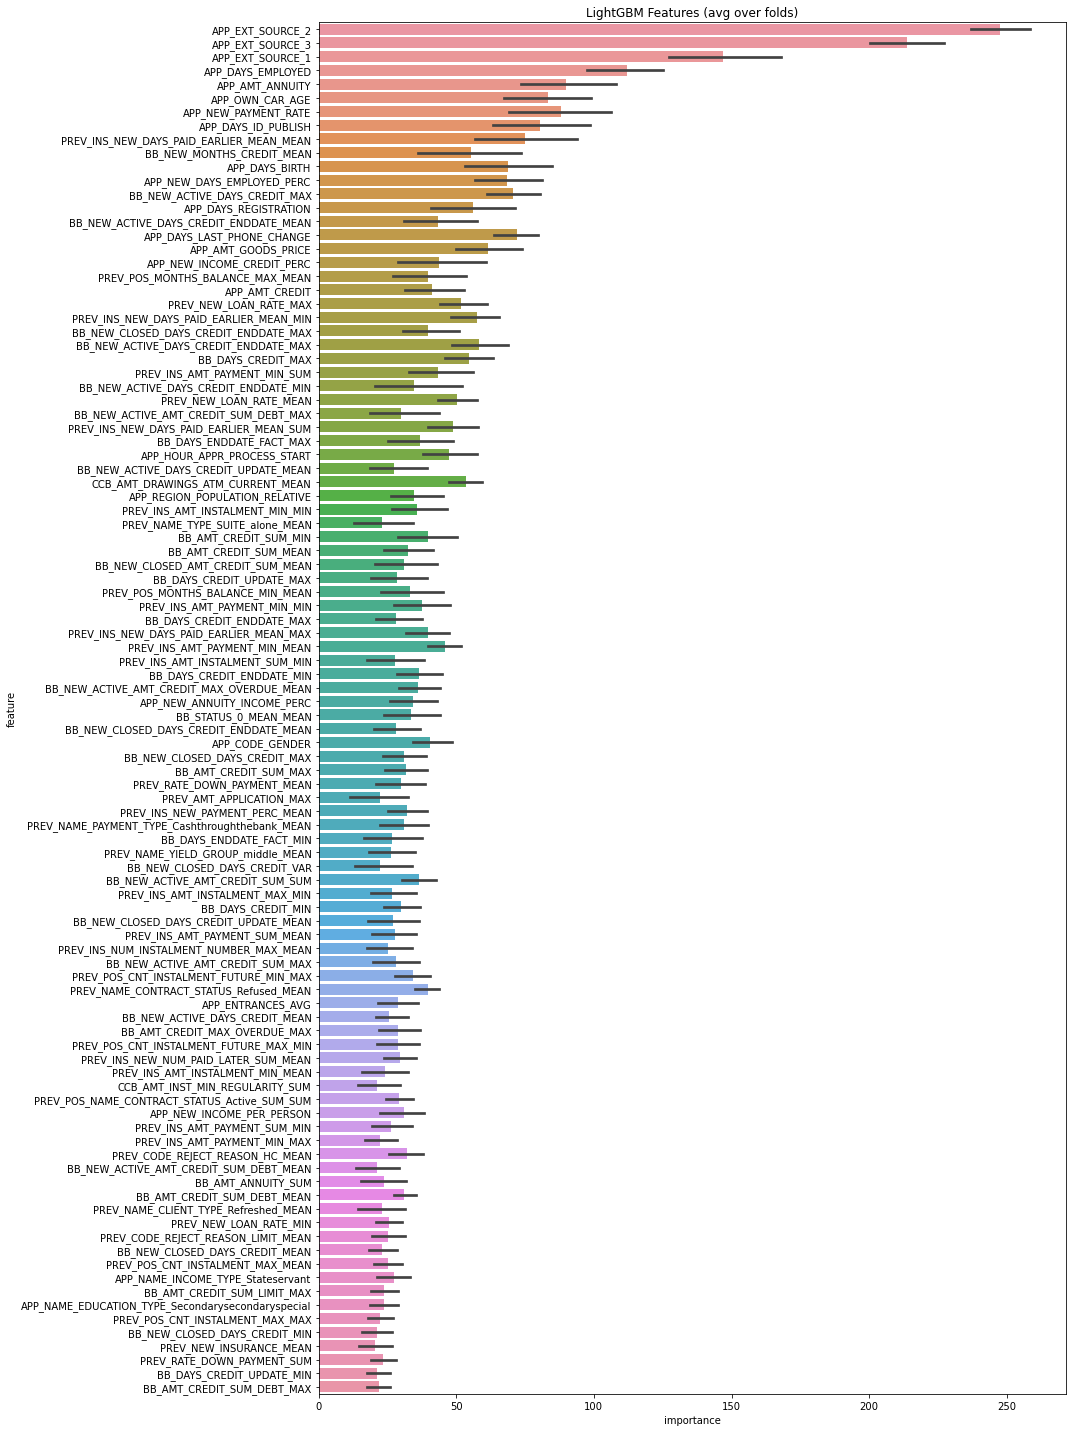

In [19]:
feat_importance = modeling(all_data)
feat_importance

In [20]:
important = best_features.sort_values(by = 'importance', ascending = False)

In [21]:
important.to_csv('Important_features.csv')

In [23]:
all_data.to_csv('All_data_manual.csv')